<hr style="height:2px;">

# Demo: Denoising of 2D cell images

This notebook demonstrates applying a CARE model for a 2D denoising task, assuming that training was already completed via [2_training.ipynb](2_training.ipynb).  
The trained model is assumed to be located in the folder `models` with the name `my_model`.

More Documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))
/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


<hr style="height:2px;">

# Raw low-SNR image and associated high-SNR ground truth

Plot the test image (with associated ground truth) and define its image axes, which will be needed later for CARE prediction.

image size = (256, 256)
image axes = YX


Text(0.5,1,'high')

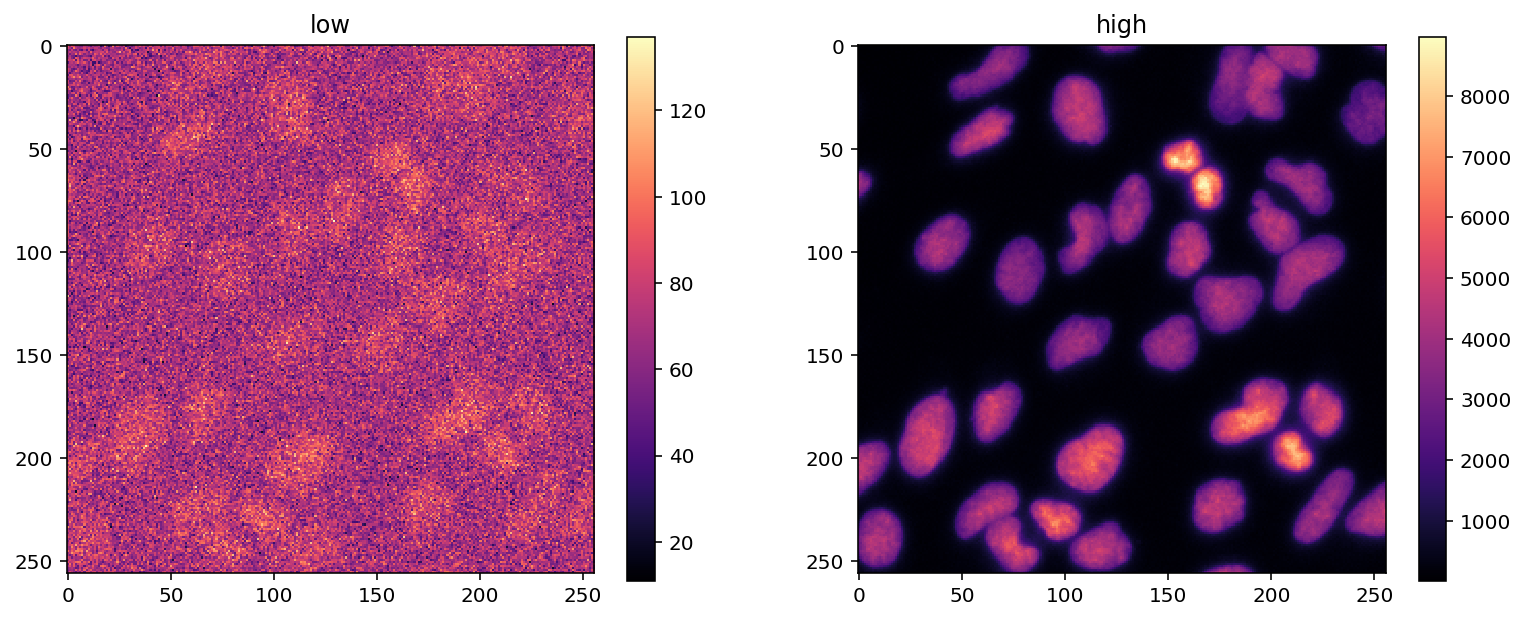

In [2]:
y = imread('data/bbc006/test/GT/img_0000.tif')
x = imread('data/bbc006/test/low/img_0000.tif')

axes = 'YX'
print('image size =', x.shape)
print('image axes =', axes)


plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("low")
plt.subplot(1,2,2)
plt.imshow(y, cmap  ="magma")
plt.colorbar()
plt.title("high")


<hr style="height:2px;">

# CARE model

Load trained model (located in base directory `models` with name `my_model`) from disk.  
The configuration was saved during training and is automatically loaded when `CARE` is initialized with `config=None`.

In [3]:
model = CARE(config=None, name='my_model', basedir='models')

Loading network weights from 'weights_best.h5'.


## Apply CARE network to raw image

Predict the restored image (image will be successively split into smaller tiles if there are memory issues).

In [4]:
%%time
restored = model.predict(x, axes)

CPU times: user 736 ms, sys: 316 ms, total: 1.05 s
Wall time: 1.08 s


Alternatively, one can directly set `n_tiles` to an appropriate value to avoid the time overhead from multiply retries in case of memory issues.

<hr style="height:2px;">

# Raw low/high-SNR image and denoised image via CARE network

Plot the test image pair and the predicted restored image (middle).

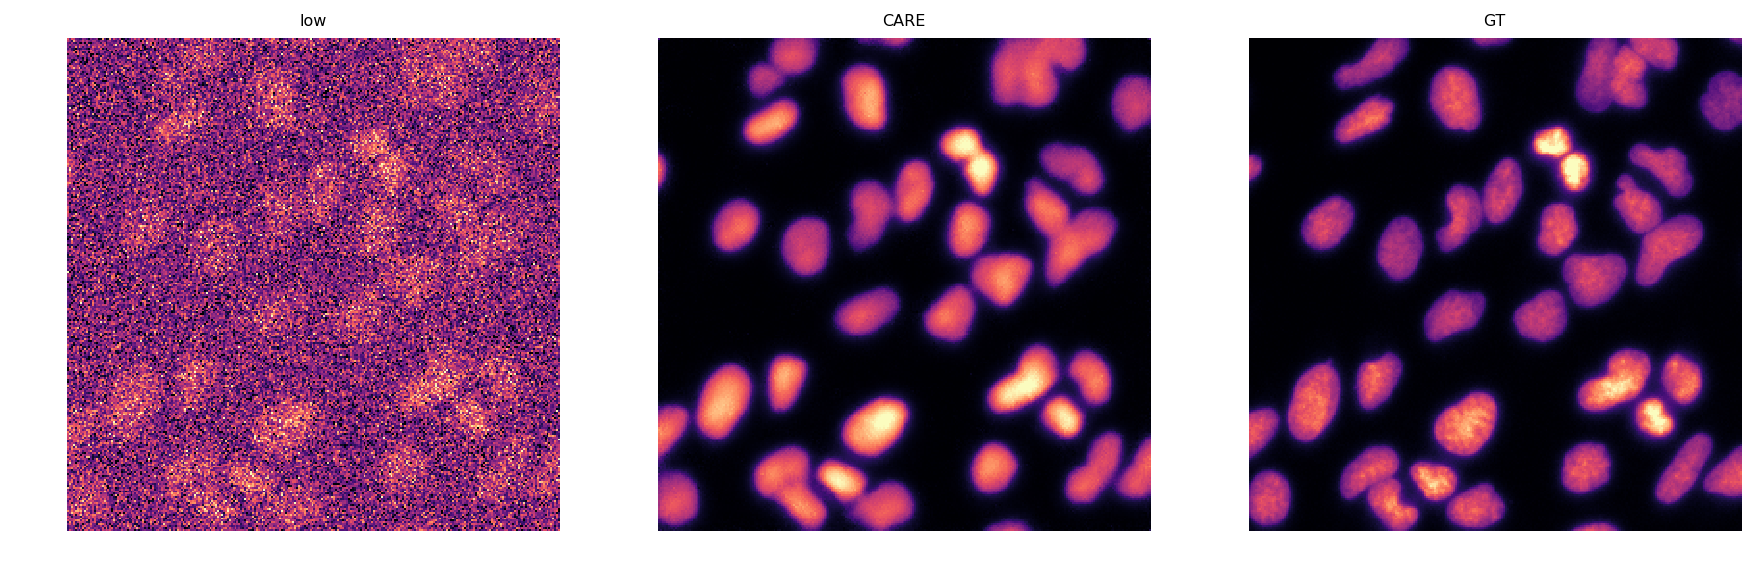

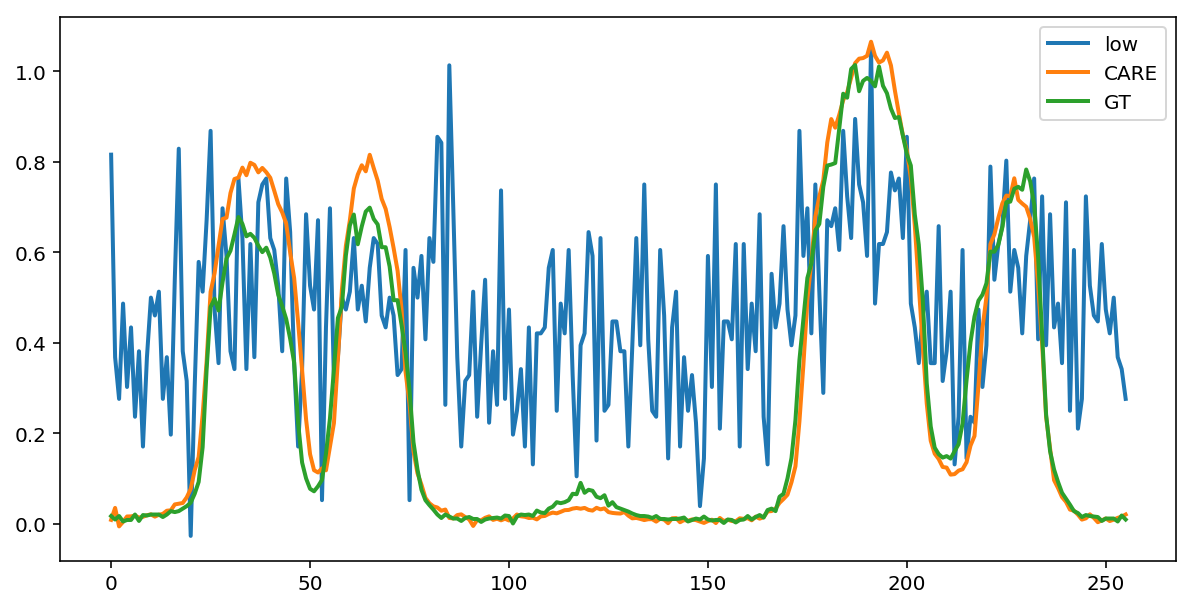

In [5]:
from csbdeep.utils import normalize



plt.figure(figsize=(15,10))
plot_some(np.stack([x,restored,y]),
          title_list=[['low','CARE','GT']], 
          pmin=2,pmax=99.8);

plt.figure(figsize=(10,5))
for _x,_name in zip((x,restored,y),('low','CARE','GT')):
    plt.plot(normalize(_x,1,99.7)[180], label = _name, lw = 2)
plt.legend()


## Save restored image

Save the restored image as a ImageJ-compatible TIFF image, i.e. the image can be opened in ImageJ/Fiji with correct axes semantics.

Path('results').mkdir(exist_ok=True)
save_tiff_imagej_compatible('results/input.tif',  x,        axes)
save_tiff_imagej_compatible('results/output.tif', restored, axes)